In [1]:
import torch
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *
from miniai.datasets import DataLoaders

from miniai.learner import Learner, Callback

from fastprogress import progress_bar,master_bar

In [2]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close
     

/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
logging.disable(logging.WARNING)

# Learner

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [7]:
bs = 1024
tds = dsd.with_transform(transformi)

In [8]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [9]:
n, nh = 28*28, 50
def get_model():
    return torch.nn.Sequential(torch.nn.Linear(n, nh), torch.nn.ReLU(), torch.nn.Linear(nh, 10))
model = get_model()

In [10]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

# Some callbacks

In [11]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [12]:
metric = MulticlassAccuracy()
metric.update(torch.tensor([0,2,1,3]), torch.tensor([0,1,2,3]))
metric.compute()

tensor(0.50)

In [13]:
metric.reset()
metric.compute()

tensor(nan)

In [14]:
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k,v in x.items()}
    if isinstance(x, list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype == torch.float16 else res

In [15]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d):
        print(d)
    def before_fit(self, learn):
        learn.metrics = self
    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [24]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        self.device = device
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)
            
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [25]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB('mps'), metrics])
learn.fit(1)

AttributeError: preds

# Metric

In [17]:
class Metric:
    def __init__(self):
        self.reset()
    def reset(self):
        self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs):
        return inps

In [18]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps == targs).float().mean()

In [19]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [20]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

# Some callbacks

In [46]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()
    def before_fit(self):
        self.learn.model.to(self.device)
    def before_batch(self):
        self.learn.batch = to_device(self.learn.batch, device=self.device)

In [47]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [48]:
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x,list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [49]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
    def _log(self, d):
        print(self.learn.epoch, self.learn.model.training, d)
        
    def before_fit(self):
        self.learn.metrics = self
        
    def before_epoch(self):
        [o.reset() for o in self.all_metrics.values()]
        
    def after_epoch(self):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)
        
    def aftert_batch(self):
        x,y = to_cpu(self.learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(self.learn.preds), y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))

In [50]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

0 True {'accuracy': 'nan', 'loss': '0.000', 'epoch': 0, 'train': True}
0 False {'accuracy': 'nan', 'loss': '0.000', 'epoch': 0, 'train': False}


## Final TESTS

In [11]:
from miniai.learner import Learner, Callback, MetricsCB, TrainCB, DeviceCB, ProgressCB, MomentumLearner, LRFinderCB
from torcheval.metrics import MulticlassAccuracy,Mean

accuracy,loss,epoch,train
0.601,1.191,0,train
0.726,0.762,0,eval


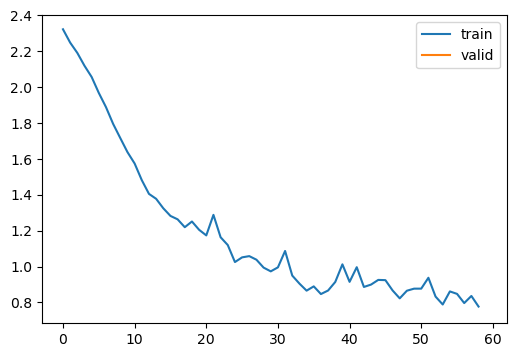

In [12]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Train Learner and Momentum Learner

accuracy,loss,epoch,train
0.672,0.964,0,train
0.793,0.575,0,eval
0.824,0.495,1,train
0.828,0.491,1,eval
0.846,0.433,2,train
0.834,0.452,2,eval
0.857,0.403,3,train
0.852,0.420,3,eval
0.863,0.385,4,train
0.847,0.421,4,eval


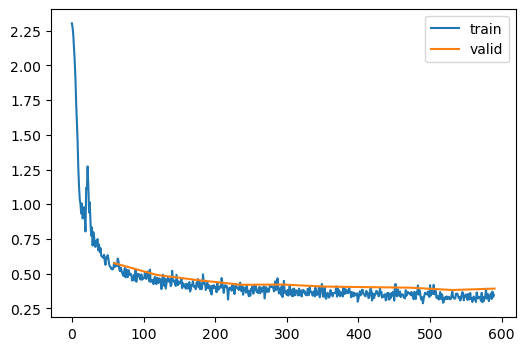

In [16]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(10)

## LRFinderCB

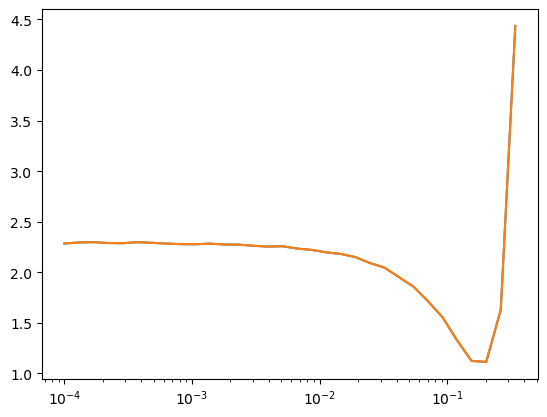

In [14]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

## ExponentialLR

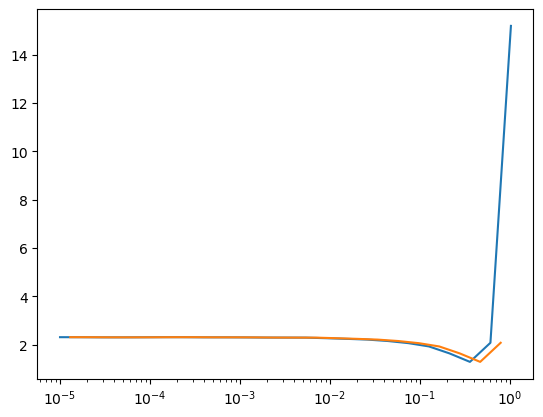

In [15]:
from miniai.learner import lr_find

MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()